<h1 style="font-size: 40px; margin-bottom: 0px;">12.2 Clustering and Differential Expression Analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Today, we'll continue to play around with our RNA-seq counts by looking at two other ways we can cluster our data, and then we'll perform differential expression analysis to obtain a <code>.csv</code> file that we can then play around in and explore more using Python. 

As we're performing the differential expression analysis, we'll break it up into smaller steps to review what Dr. Ingolia taught in lecture to see what's going on under the hood.

<strong>Learning objectives:</strong>

<ul>
    <li>Continue to explore clustering</li>
    <li>Review differential expression analysis</li>
    <li>Perform differential expression analysis</li>
    <li>Visualize results as an MA plot</li>
</ul>

<h1 style="font-size: 40px; margin-bottom: 0px;">Load in packages</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Like our previous lesson, we'll first load in the packages that we'll need for today's analysis, and then we'll briefly review some of the initial steps of DESeq2 that we did previously to set up for our principal component analysis. We'll have the same set up here in this notebook in order to perform some other clustering methods.

Two new packages that we'll make use of today are <code>pheatmap</code> to generate heatmaps and <code>viridis</code> to get a specific type of color palette. And we'll still be making use of <code>DESeq2</code>, <code>ggplot2</code>, and <code>hexbin</code>. 

In [1]:
library(DESeq2)
library(ggplot2)
BiocManager::install("hexbin")
library(pheatmap)
library(viridis)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



<h1 style="font-size: 40px; margin-bottom: 0px;">Make your own color palette for this notebook</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

So to start off with today, we'll play around with some color palettes. Specifically, we can take a look at the viridis colormap, which you might recognize as the default colormap for matplotlib in Python when we didn't specify a colormap for our imported image files. We'll then make use of these color palettes that we create for visualizing our clustering results.

<a href="https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html" rel="noopener noreferrer"><u>A helpful vignette on the viridis color scale can be found here</u></a> (Rudis, Ross and Garnier). It describes the different color scales contained within the viridis package, and also demonstrates how the color scales, particularly viridis (designed by Eric Firing), is useful for data visualization that is readable by those with different types of color-blindness, allowing your data visualizations to be more accessible. The vignette also contains a fun visualization that we can use to test out our own color palettes as well.

<h2>Viridis color palette</h2>

We can use the <code>viridis()</code> function to quickly generate a list of hex codes corresponding to the viridis color palette. We can provide it with the number of hex codes we want it to generate, and it will generate a list spanning the viridis color map.

In [3]:
head(viridis(255), 5)

[1] "#440154FF" "#440256FF" "#450457FF" "#450559FF" "#46075AFF"

Now let's see how the colors work in a visualization, pulling the code from the vignette with some slight modifications:

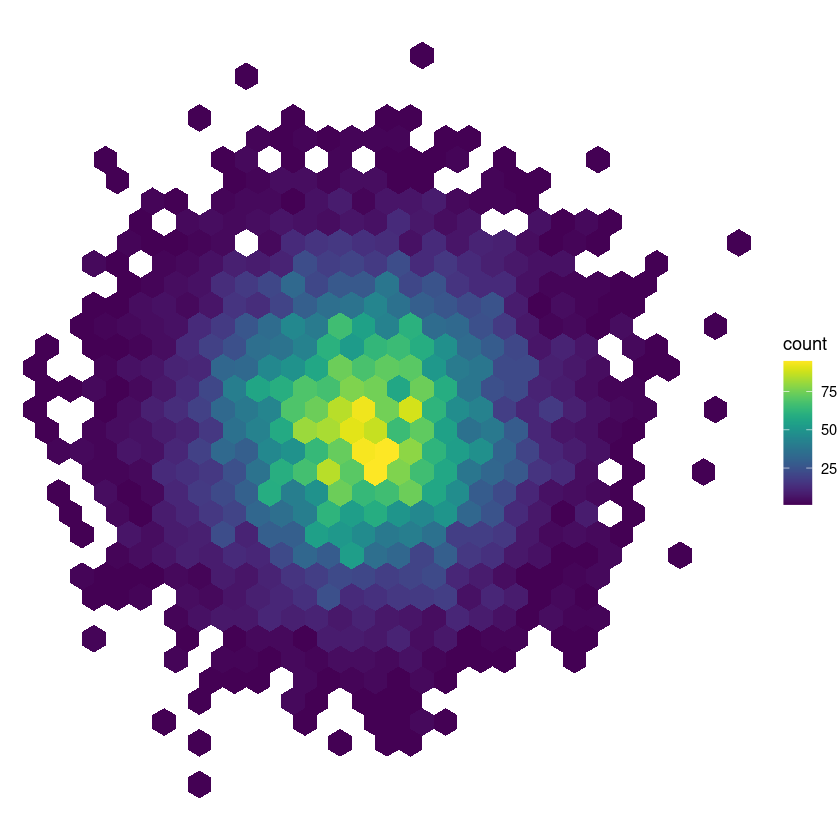

In [4]:
ggplot(data.frame(x = rnorm(10000), y = rnorm(10000)), aes( x = x, y = y)) +
    geom_hex() +
    theme_void() +
    coord_fixed() +
    scale_fill_gradientn(colors=viridis(255))

<h2>Setting up a color palette using <code>colorRampPalette()</code></h2>

Plenty of different color maps exist both for R and in Python, which can be used for data visualizations such as heatmaps. However, sometimes you might feel that existing color maps don't capture exactly how you want your data to be visualized stylistically. In that case, you can make use of the <code>colorRampPalette()</code> function to generate your own graded color palettes. 

<a href="https://www.rdocumentation.org/packages/dichromat/versions/1.1/topics/colorRampPalette" rel="noopener noreferrer"><u>Documentation for <code>colorRampPalette()</code> is here.</u></a>

So you can provide the function with a list of your colors (either names, hex codes, etc) that you want it to span, and it can generate a gradient of colors that span the ones you specify:

In [12]:
my.fav.col.map <- colorRampPalette(colors = c("black", "purple", "lavender"))(255)

In [13]:
my.fav.col.map

[1] "#000000" "#010001" "#020003" "#030005" "#050107" "#060109" "#07010B"
  [8] "#08010D" "#0A020F" "#0B0211" "#0C0212" "#0D0214" "#0F0316" "#100318"
 [15] "#11031A" "#12031C" "#14041E" "#150420" "#160422" "#170423" "#190525"
 [22] "#1A0527" "#1B0529" "#1C052B" "#1E062D" "#1F062F" "#200631" "#220633"
 [29] "#230734" "#240736" "#250738" "#27073A" "#28083C" "#29083E" "#2A0840"
 [36] "#2C0842" "#2D0944" "#2E0945" "#2F0947" "#310949" "#320A4B" "#330A4D"
 [43] "#340A4F" "#360A51" "#370B53" "#380B55" "#390B56" "#3B0B58" "#3C0C5A"
 [50] "#3D0C5C" "#3E0C5E" "#400C60" "#410D62" "#420D64" "#440D66" "#450D67"
 [57] "#460E69" "#470E6B" "#490E6D" "#4A0E6F" "#4B0F71" "#4C0F73" "#4E0F75"
 [64] "#4F0F77" "#501078" "#51107A" "#53107C" "#54107E" "#551180" "#561182"
 [71] "#581184" "#591186" "#5A1288" "#5B1289" "#5D128B" "#5E128D" "#5F138F"
 [78] "#611391" "#621393" "#631395" "#641497" "#661499" "#67149A" "#68149C"
 [85] "#69159E" "#6B15A0" "#6C15A2" "#6D15A4" "#6E16A6" "#7016A8" "#7116AA"
 [92] "#7216AB" "#7317AD" "#7517AF" "#7617B1" "#7717B3" "#7818B5" "#7A18B7"
 [99] "#7B18B9" "#7C18BB" "#7D19BC" "#7F19BE" "#8019C0" "#8119C2" "#831AC4"
[106] "#841AC6" "#851AC8" "#861ACA" "#881BCC" "#891BCD" "#8A1BCF" "#8B1BD1"
[113] "#8D1CD3" "#8E1CD5" "#8F1CD7" "#901CD9" "#921DDB" "#931DDD" "#941DDE"
[120] "#951DE0" "#971EE2" "#981EE4" "#991EE6" "#9A1EE8" "#9C1FEA" "#9D1FEC"
[127] "#9E1FEE" "#A020F0" "#A021F0" "#A123F0" "#A124F0" "#A226F0" "#A227F0"
[134] "#A329F0" "#A32AF0" "#A42CF0" "#A42EF0" "#A52FF0" "#A631F0" "#A632F0"
[141] "#A734F1" "#A735F1" "#A837F1" "#A838F1" "#A93AF1" "#A93CF1" "#AA3DF1"
[148] "#AB3FF1" "#AB40F1" "#AC42F1" "#AC43F1" "#AD45F1" "#AD46F1" "#AE48F2"
[155] "#AE4AF2" "#AF4BF2" "#AF4DF2" "#B04EF2" "#B150F2" "#B151F2" "#B253F2"
[162] "#B255F2" "#B356F2" "#B358F2" "#B459F2" "#B45BF2" "#B55CF3" "#B65EF3"
[169] "#B65FF3" "#B761F3" "#B763F3" "#B864F3" "#B866F3" "#B967F3" "#B969F3"
[176] "#BA6AF3" "#BB6CF3" "#BB6DF3" "#BC6FF4" "#BC71F4" "#BD72F4" "#BD74F4"
[183] "#BE75F4" "#BE77F4" "#BF78F4" "#BF7AF4" "#C07BF4" "#C17DF4" "#C17FF4"
[190] "#C280F4" "#C282F4" "#C383F5" "#C385F5" "#C486F5" "#C488F5" "#C58AF5"
[197] "#C68BF5" "#C68DF5" "#C78EF5" "#C790F5" "#C891F5" "#C893F5" "#C994F5"
[204] "#C996F5" "#CA98F6" "#CA99F6" "#CB9BF6" "#CC9CF6" "#CC9EF6" "#CD9FF6"
[211] "#CDA1F6" "#CEA2F6" "#CEA4F6" "#CFA6F6" "#CFA7F6" "#D0A9F6" "#D1AAF7"
[218] "#D1ACF7" "#D2ADF7" "#D2AFF7" "#D3B0F7" "#D3B2F7" "#D4B4F7" "#D4B5F7"
[225] "#D5B7F7" "#D6B8F7" "#D6BAF7" "#D7BBF7" "#D7BDF7" "#D8BFF8" "#D8C0F8"
[232] "#D9C2F8" "#D9C3F8" "#DAC5F8" "#DAC6F8" "#DBC8F8" "#DCC9F8" "#DCCBF8"
[239] "#DDCDF8" "#DDCEF8" "#DED0F8" "#DED1F8" "#DFD3F9" "#DFD4F9" "#E0D6F9"
[246] "#E1D7F9" "#E1D9F9" "#E2DBF9" "#E2DCF9" "#E3DEF9" "#E3DFF9" "#E4E1F9"
[253] "#E4E2F9" "#E5E4F9" "#E6E6FA"

<a href="https://www.nceas.ucsb.edu/sites/default/files/2020-04/colorPaletteCheatsheet.pdf" rel="noopener noreferrer"><u>A helpful cheatsheet for colors and other color palettes can be found here by Melanie Frazier.</u></a>

You can then specify how many hex codes to generate by slightly modifying your line of code:

In [ ]:
#See above code cell

Then, you can provide this color map to your functions for data visualizations, allowing you to create custom color maps based on the needs of your individual figures or the data/information that you are trying to convey.

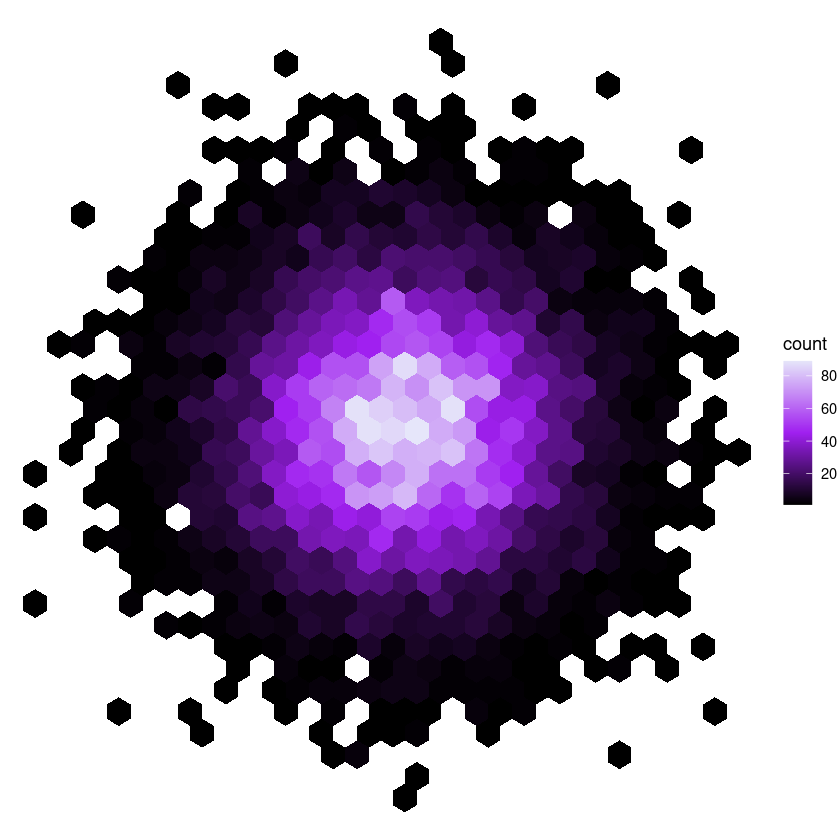

In [14]:
ggplot(data.frame(x = rnorm(10000), y = rnorm(10000)), aes( x = x, y = y)) +
    geom_hex() +
    theme_void() +
    coord_fixed() +
    scale_fill_gradientn(colors=my.fav.col.map)

<h1>Prepare your <code>DESeqDataSet</code></h1>

Since this is a new notebook, we'll need to bring in our counts matrix and conditions matrix again and use them to create a <code>DESeqDataSet</code> for us to use to do some more clustering. 

Let's bring over our initial code from notebook 12-1 for setting up our <code>DESeqDataSet</code>

In [15]:
#These lines of code are pulled from notebook 12-1
#Refer back to 12-1 for detailed breakdowns

counts <- read.csv('/home/jovyan/MCB201B_F2025/Week_10/class-set/1M_class_counts_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

conditions <- read.csv('/home/jovyan/MCB201B_F2025/Week_10/class-set/1M_class_conditions_matrix.csv',
                       stringsAsFactors=FALSE,
                       row.names=1
                       )

means <- apply(counts, 1, mean)
counts <- counts[which(means>0), ]

dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = conditions,
                              design = ~ condition
                              )

dds <- estimateSizeFactors(dds)

rld <- rlog(dds, blind=FALSE)
rld.values <- assay(rld)
top500.var.rld <- head(rld.values[order(rowVars(rld.values), decreasing=TRUE), ], 500)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


<h1 style="font-size: 40px; margin-bottom: 0px;">Generate a distance matrix</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Recall from Dr. Ingolia's clustering lecture that we can determine the similarities and dissimilarities of our samples by calculating their distances from one another, then using the resulting distance matrix to identify clusters of closely grouped samples. 

<h2>Calculate distances between replicates</h2>

To do this, we'll make use of the <code>dist()</code> function, which computes the distance matrix of a given data matrix. <a href="https://stat.ethz.ch/R-manual/R-devel/library/stats/html/dist.html" rel="noopener noreferrer"><u>Documentation for <code>dist()</code> is here.</u></a> If we dig into the documentation, we can see that it calculates the Euclidean distance between the rows, and it will output an object that can the be converted to a matrix via the function <code>as.matrix()</code>.

In [17]:
#Detailed breakdown below this code cell
rep.distances <- dist(t(assay(rld)))

<h2>Let's break down the code:</h2>

<code>rep.distances</code>

This is the variable to which we are saving our <code>dist</code> object.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>dist()</code>

This is the function to calculate the Euclidean distance between each row.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>t(assay(rld))</code>

Here, we provide it with the transposed rlog transformed counts matrix. Like with principal component analysis, the distances are determined between the rows, and since we are more interested in the similarities/differences between each of our replicates, we will provide it with a transposed matrix of our rlog transformed counts using the <code>t()</code> function.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

Let's take a look at the output:

In [18]:
rep.distances
#You should see the calculated Euclidean distances
#The comparison is based on the intersection of the col and the row
#So you read the col and row to know which two samples are the two whose distance is being calculated

          ctrl_g1 tazko_g1  ctrl_g2 tazko_g2  ctrl_g3 tazko_g3  ctrl_g4
tazko_g1 32.38840                                                      
ctrl_g2  22.18899 32.59033                                             
tazko_g2 32.43072 21.15488 32.48130                                    
ctrl_g3  23.53988 33.12193 22.74204 32.80724                           
tazko_g3 35.26155 24.09265 34.57934 23.43546 34.26963                  
ctrl_g4  27.03558 36.81646 27.73585 37.23293 30.14657 42.67223         
tazko_g4 33.42773 21.80397 33.33407 21.53334 34.11094 22.28150 38.32434
ctrl_g5  22.50788 32.88224 21.75767 32.73467 23.43105 35.62825 25.83839
tazko_g5 33.69335 22.47800 33.07015 22.27967 33.94586 25.13006 37.06371
ctrl_g6  23.15481 33.22617 22.33817 32.87493 23.93274 35.70099 26.43087
tazko_g6 34.35729 23.61678 33.47274 22.75849 33.06269 22.23566 39.88520
ctrl_g7  22.77998 33.14379 22.26489 32.83138 23.96072 35.40728 27.04665
tazko_g7 36.08406 25.22139 35.00662 24.65331 35.15424 21.67440 4

<h2>Convert to a matrix</h2>

Now we can convert our <code>dist</code> object into a matrix that we can then use to generate a heatmap of our data based on the distance values for each point in our matrix. To do this, we'll use <a href="https://stat.ethz.ch/R-manual/R-devel/library/base/html/matrix.html" rel="noopener noreferrer"><u>a standard function called <code>as.matrix()</code></u></a>, which can convert our <code>dist</code> object into a 2D matrix. This function takes the object that you pass it and attempts to coerce it into a matrix.

In [19]:
#We can coerce it into a matrix, which will essentially mirror along the diagonal
rep.distances.matrix <- as.matrix(rep.distances)

Let's take a look at how our distance matrix looks:

In [20]:
rep.distances.matrix
#The diagonal is all 0 because it is a comparison to the same sample
#In other words, no difference (no distance) because they are identical

,ctrl_g1,tazko_g1,ctrl_g2,tazko_g2,ctrl_g3,tazko_g3,ctrl_g4,tazko_g4,ctrl_g5,tazko_g5,ctrl_g6,tazko_g6,ctrl_g7,tazko_g7,ctrl_g8,tazko_g8,ctrl_g9,tazko_g9
ctrl_g1,0.00000,32.38840,22.18899,32.43072,23.53988,35.26155,27.03558,33.42773,22.50788,33.69335,23.15481,34.35729,22.77998,36.08406,23.22450,33.64676,25.81093,36.58732
tazko_g1,32.38840,0.00000,32.59033,21.15488,33.12193,24.09265,36.81646,21.80397,32.88224,22.47800,33.22617,23.61678,33.14379,25.22139,32.80293,22.64552,34.05757,26.23047
ctrl_g2,22.18899,32.59033,0.00000,32.48130,22.74204,34.57934,27.73585,33.33407,21.75767,33.07015,22.33817,33.47274,22.26489,35.00662,21.75578,33.43486,23.56646,35.50989
tazko_g2,32.43072,21.15488,32.48130,0.00000,32.80724,23.43546,37.23293,21.53334,32.73467,22.27967,32.87493,22.75849,32.83138,24.65331,32.29583,22.60696,33.59084,25.49723
ctrl_g3,23.53988,33.12193,22.74204,32.80724,0.00000,34.26963,30.14657,34.11094,23.43105,33.94586,23.93274,33.06269,23.96072,35.15424,22.77761,34.88195,22.92462,36.46592
tazko_g3,35.26155,24.09265,34.57934,23.43546,34.26963,0.00000,42.67223,22.28150,35.62825,25.13006,35.70099,22.23566,35.40728,21.67440,34.21535,24.18259,33.84224,22.83314
ctrl_g4,27.03558,36.81646,27.73585,37.23293,30.14657,42.67223,0.00000,38.32434,25.83839,37.06371,26.43087,39.88520,27.04665,42.58366,28.16746,37.26208,32.24923,42.72230
tazko_g4,33.42773,21.80397,33.33407,21.53334,34.11094,22.28150,38.32434,0.00000,33.37879,22.05645,33.42469,22.18861,33.12693,22.50734,32.80718,21.06824,33.99592,23.43797
ctrl_g5,22.50788,32.88224,21.75767,32.73467,23.43105,35.62825,25.83839,33.37879,0.00000,32.75093,21.32721,33.78379,21.29059,35.58343,21.58968,32.80797,24.35651,35.98043
tazko_g5,33.69335,22.47800,33.07015,22.27967,33.94586,25.13006,37.06371,22.05645,32.75093,0.00000,32.36543,23.34922,32.33352,24.05295,32.30864,22.00278,33.01911,25.61552


<h1>Plot a heatmap of sample distances</h1>

Now that we have a matrix of the Euclidean distances between our samples, we can then generate a heatmap of their distances while clustering our samples based on how close or far away they are from each other.

For this type of plotting, we'll make use of the pheatmap package. <a href="https://cran.r-project.org/web/packages/pheatmap/pheatmap.pdf" rel="noopener noreferrer"><u>Documentation for the pheatmap package is here.</u></a> Specifically, we'll make use of the <code>pheatmap()</code> function, which will allow us to cluster our data based on their Euclidean distances that we calculated using the <code>dist()</code> function.

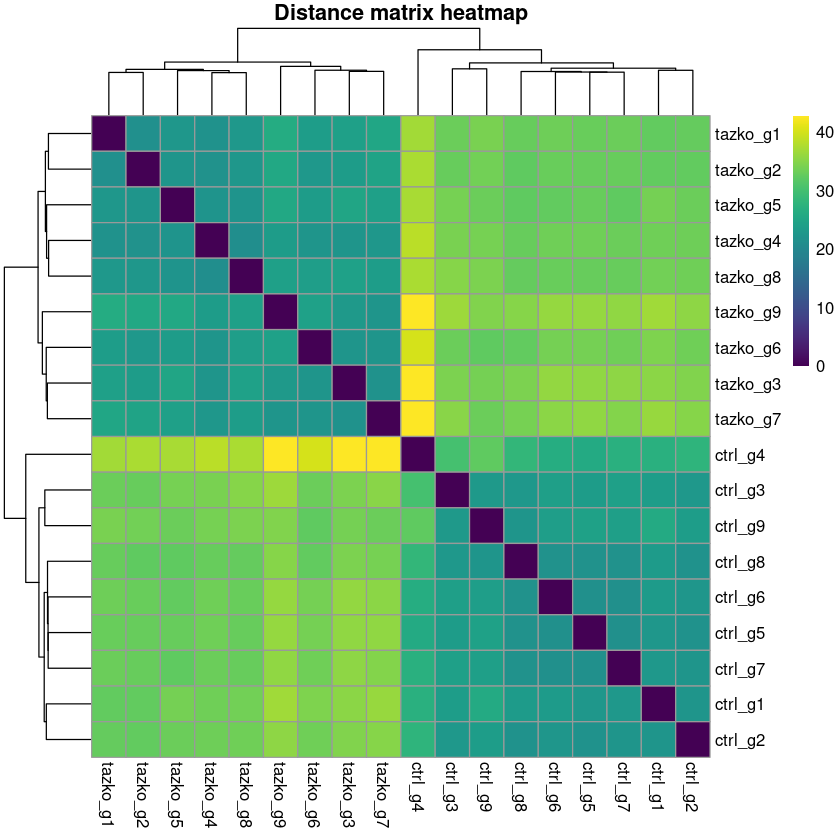

In [26]:
#Here, we use pheatmap to cluster and generate a heatmap using the distances that we've calculated
pheatmap(rep.distances.matrix,
         clustering_distance_rows=rep.distances,
         clustering_distance_cols=rep.distances,
         col=viridis(255),
         main='Distance matrix heatmap',
         # filename='/home/jovyan/MCB201B_F2025/Week_10/differential-expression-analysis/clustering-analysis/1M_class_distance_heatmap.pdf'
         )

You should see a heatmap colored with the color map that you specified, where the diagonal corresponds to a zero because it is the distance between the sample itself. 

We can identify groupings of our data based on the dendogram built up based on the distances (recall from Dr. Ingolia's lecture), and we can also see them as the larger squares that we see.

<h1 style="font-size: 40px; margin-bottom: 0px;">Perform hierarchical clustering</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Another way of determining the similarities and dissimilarities of our samples is to perform hierarchical clustering based on our top 500 genes with the highest variance.

We'll continue to make use of the <code>pheatmap()</code> function, but we'll provide it with a different set of arguments.

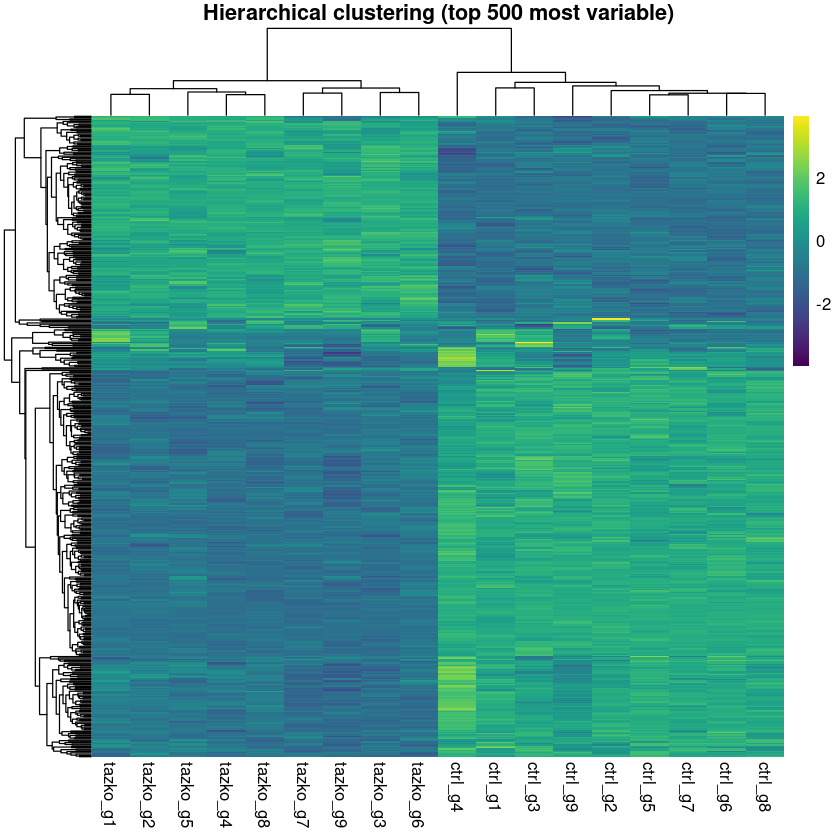

In [39]:
#We can adjust how we use pheatmap() by changing the parameters we use
#And also by feeding it our top 500 most variably expressed genes for hierarchical clustering
#So rather than using the calculated Euclidean distances, this is using the top 500 variable genes
pheatmap(top500.var.rld,
         color=viridis(255),
         scale='row',
         show_rownames=FALSE,
         main='Hierarchical clustering (top 500 most variable)',
         # filename='/home/jovyan/MCB201B_F2025/Week_10/differential-expression-analysis/clustering-analysis/1M_class_hierarchical_heatmap.pdf'
        )

You should see a heatmap that looks a little different than the heatmap that we generated earlier. You can see how our data is grouped together, but now we can also see clusters of our genes, where we have clusters of genes that are overexpressed in our TAZ KO samples and groups of genes that exhibit reduced expression in our KO samples. 

You might notice that the legend for this figure looks different than that of our distance matrix heatmap. This is due to the fact that we supplied the argument <code>scale="row"</code>. This argument centers the mean of the data around 0 and scales the standard deviation to be 1 for each row (each of the top 500 genes), allowing differences within a row to be more apparent. This is helpful when we want to visualize and compare relative changes between samples without having our visualization dominated by a few highly expressed genes. You'll then need to keep in mind that this means that you then cannot say that one gene is more or less highly expressed than another using this visualization since that informaiton is lost when we scale our data for visualization. 

<h1 style="font-size: 40px; margin-bottom: 0px;">Differential expression analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Here, we'll return to our <code>DESeqDataSet</code> to finish up our differential expression analysis. Recall from Dr. Ingolia's lecture that we've already performed some of the intial steps for differential expression analysis, where we estimated the size factors in order to account for differences in sequencing depth.

<h2>Estimate Dispersions</h2>

The next step is to then estimate the spread of our measurements, otherwise referred to as the dispersion. DESeq2 calculates the estimated dispersion (&#593;) as a function of the mean (&micro;) and variance. In other words, the estimated dispersion is the expected spread of the data for a given mean based on your data. This allows DESeq2 to identify what is likely to be true variation in the data resulting from biological or technical effects by shrinking the dispersion  of each gene towards the calculated estimated value for that specific mean. This can be thought of as modeling what the noise is for our experiment in order to distinguish biological and technical differences in our samples from what are just noise in our measurements.

We'll do this by making use of the <code>estimateDispersions()</code> function, which is part of the DESeq2 package.

Like with our other intermediate calculations, we place the output into our <code>DESeqDataSet</code>.

In [40]:
dds <- estimateDispersions(dds)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



Then we can visualize the dispersion estimate using the <code>plotDispEsts()</code> function.

In [42]:
getwd()

[1] "/home/jovyan/MCB201B_F2025/Week_12"

In [43]:
#Remove the first and last lines if you want to take a look at the output within the notebook
#Otherwise, our plot is generated to our pdf file that we open
#The last line closes the pdf file
pdf('../Week_10/differential-expression-analysis/1M_class_dispersion_estimate.pdf')
plotDispEsts(dds)
dev.off()

agg_record_1959191455 
                    2

In the plot, each dot corresponds to a single gene plotted with its mean on the X-axis and its calculated dispersion on the Y-axis. The red line is the estimated dispersion based on your whole dataset. A "good" dispersion plot should have genes following the estimated dispersion. The blue indicates the final dispersion after shrinkage, essentially removing what variation may be just due to noise in the measurements. The dots with the genes showing potential biological or technical variation greater than the expected noise marked with a blue outline.

What you would normally expect to see is a fitted line that increases in dispersion as the mean decreases (inversely correlated to mean). This is due to the fact that noise has a greater impact (accounts for more of the variation) when the mean is smaller.

<h2>Hypothesis testing: negative binomial Wald test to determine significance</h2>

Finally, we'll use the Wald test to detect differentially expressed genes and determine if they are significant. DESeq2 models expression based on a negative binomial distribution, and recall from Dr. Ingolia's lecture that the negative binomial distribution can be thought of like a Poisson distribution but able to account for extra variance as a second parameter. 

For hypothesis testing, DESeq2 sets the null hypothesis for each gene as having no difference between sample groups, so no log fold change difference (equal to 0). To test this hypothesis, DESeq2 makes use of the Wald test to compare the sample groups.

To run a Wald test on our samples, we can make use of the <code>nbinomWaldTest()</code> function.

In [44]:
dds <- nbinomWaldTest(dds)

Then we can pull out the results out of our <code>DESeqDataSet</code> using the <code>results()</code> function, and then assigning that to a new variable.

In [45]:
res <- results(dds)

Let's take a look at how our results table looks like:

In [46]:
res

log2 fold change (MLE): condition tazko vs control 
Wald test p-value: condition tazko vs control 
DataFrame with 17306 rows and 6 columns
          baseMean log2FoldChange     lfcSE       stat      pvalue       padj
         <numeric>      <numeric> <numeric>  <numeric>   <numeric>  <numeric>
A1BG-AS1   1.71740      1.5794457  0.747265   2.113634   0.0345465   0.105928
A4GALT    10.63984     -0.0641879  0.276068  -0.232508   0.8161435   0.904300
AAAS      28.13408     -0.0292543  0.173522  -0.168591   0.8661181   0.930518
AACS      28.10128     -0.1399758  0.158908  -0.880861   0.3783931   0.577812
AADAT      3.95506      0.1018438  0.421201   0.241794   0.8089399   0.901120
...            ...            ...       ...        ...         ...        ...
ZYG11A     6.76083    -0.06344736 0.3611709 -0.1756713 0.860552185 0.92673279
ZYG11B    30.51118     0.00417862 0.1708835  0.0244531 0.980491225 0.99433787
ZYX      144.91815    -0.32414657 0.0880091 -3.6831033 0.000230412 0.00167708
ZZE

<h2>Export results of differential expression analysis</h2>

Like with Python, we can export the dataframe containing our results, just with slightly different syntax.

This will output a .csv file containing the results of our differential expression analysis.

In [48]:
write.csv(res, '../Week_10/differential-expression-analysis/1M_results.csv')

<h2>Export rlog transformed counts</h2>

While we're at it, let's also export our rlog transformed counts for use later on.

In [49]:
write.csv(rld.values, '../Week_10/differential-expression-analysis/1M_rlog_counts.csv')

<h2>Generate an MA Plot</h2>

MA plots visualize the ratio or fold-change (M) on the y-axis plotted against the average or mean normalized counts (A) along the x-axis, and for RNA-seq analyses, these types of plots are commonly used to visualize differential expression levels.

With our differential expression analysis results, we can generate an MA plot from our class dataset. To do this, we'll make use of DESeq2's <code>plotMA()</code> function.

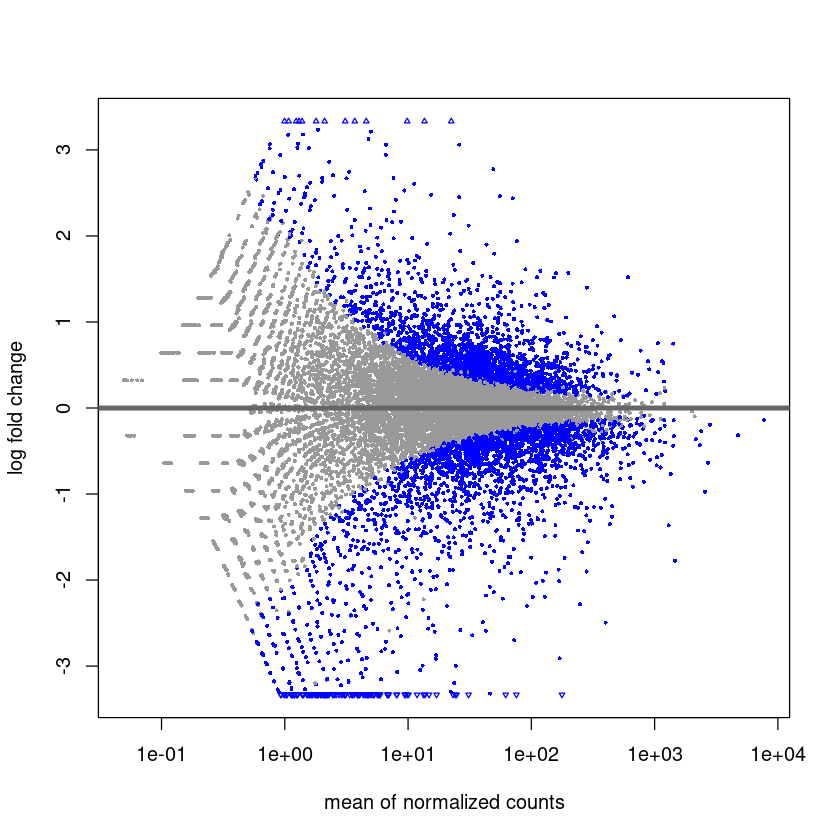

In [50]:
plotMA(res)

By default, <code>plotMA()</code> highlights genes whose p-adjusted (p-value corrected for multiple hypothesis testing) is less than 0.1.

We can supply additional arguments to the function to slightly adjust our plot:

In [56]:
pdf('../Week_10/differential-expression-analysis/1M_MA_plot.pdf')
plotMA(res,
       alpha=0.05,
       xlab='Mean of normalized counts',
       ylab='Log2 Fold Change',
       main='MA plot: 1M class dataset',
       ylim=c(-7, 7),
       colNonSig='grey',
       colSig='red',
       colLine='black',
       )
dev.off()

agg_record_2026914251 
                    2

<h2>Obtain shrunken log fold change values</h2>

As you can see, much like with our MA plot for our single replicate, genes that have a lower mean also exhibit a greater log fold change, giving the MA plot its characteristic arrowhead shape. This is due to the fact that noise in the measurements will lead to larger dispersion and a greater log fold change.

We can correct for this by calculating the shrunken log fold change. This allows us to better visualize genes whose differential expression is likely due to true biological or technical variance rather than noise. 

First, let's pull out the comparison groups from our <code>DESeqDataSet</code>:

In [57]:
resultsNames(dds)

[1] "Intercept"                  "condition_tazko_vs_control"

Then, we can call up the <code>lfcShrink()</code> function to calculate our shrunken log fold change:

In [58]:
resLFC <-lfcShrink(dds, 
                   coef='condition_tazko_vs_control'
                   )

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

Warning message in nbinomGLM(x = x, Y = YNZ, size = size, weights = weightsNZ, offset = offsetNZ, :
“the line search routine failed, unable to sufficiently decrease the function value”
Warning message in nbinomGLM(x = x, Y = YNZ, size = size, weights = weightsNZ, offset = offsetNZ, :
“the line search routine failed, unable to sufficiently decrease the function value”
Warning message in nbinomGLM(x = x, Y = YNZ, size = size, weights = weightsNZ, offset = offsetNZ, :
“the line search routine failed, unable to sufficiently decrease the function value”
Warning message in nbinomGLM(x = x, Y = YNZ, size = size, weights = weightsNZ, offset = offsetNZ, :
“the line search routine failed, unable

In [63]:
#Since we had time at the end of class, we pulled out the rows (genes) that were giving us issues when shrinking the LFC
#Usually due to some failure to converge, and these can be identified by a padj of na
#So we can subset our results table to pull out those rows (genes)
problems <- subset(res, is.na(padj))

In [66]:
#We can find the names by pulling out the rownames since the value of the index is the gene names
head(rownames(problems), 10)

[1] "AARD"     "AATBC"    "AATK"     "ABALON"   "ABCA13"   "ABCA17P" 
 [7] "ABCA4"    "ABCA6"    "ABCA9"    "ABCB10P3"

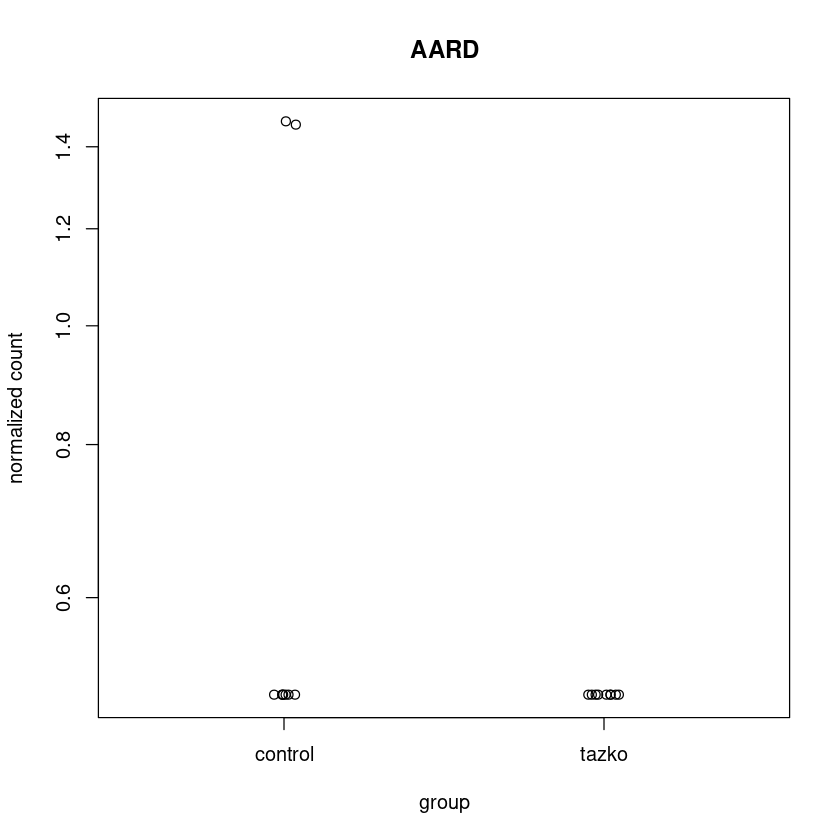

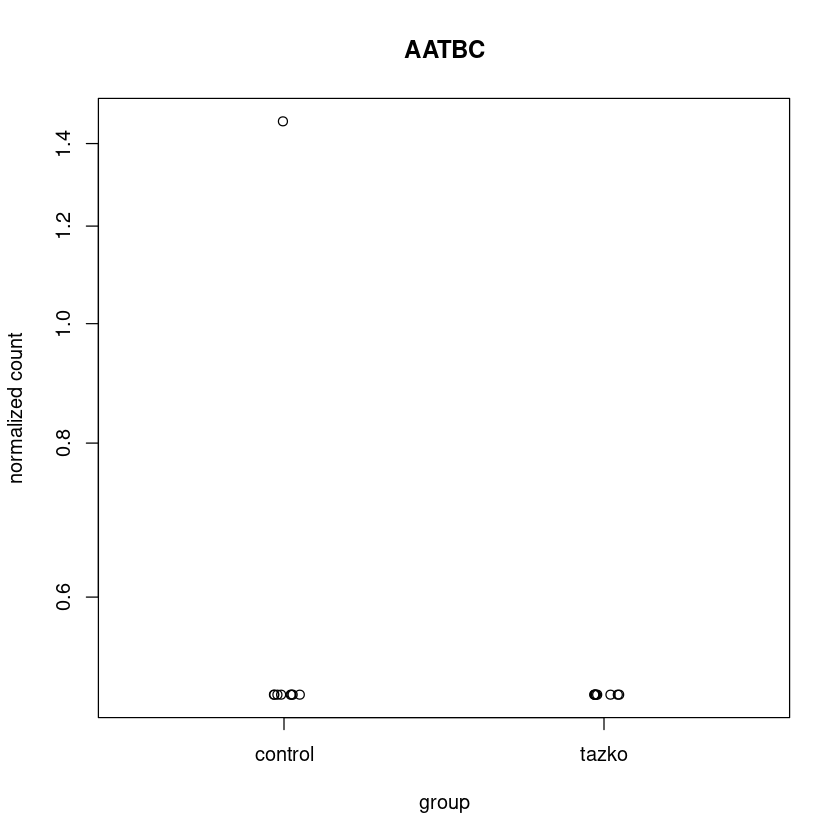

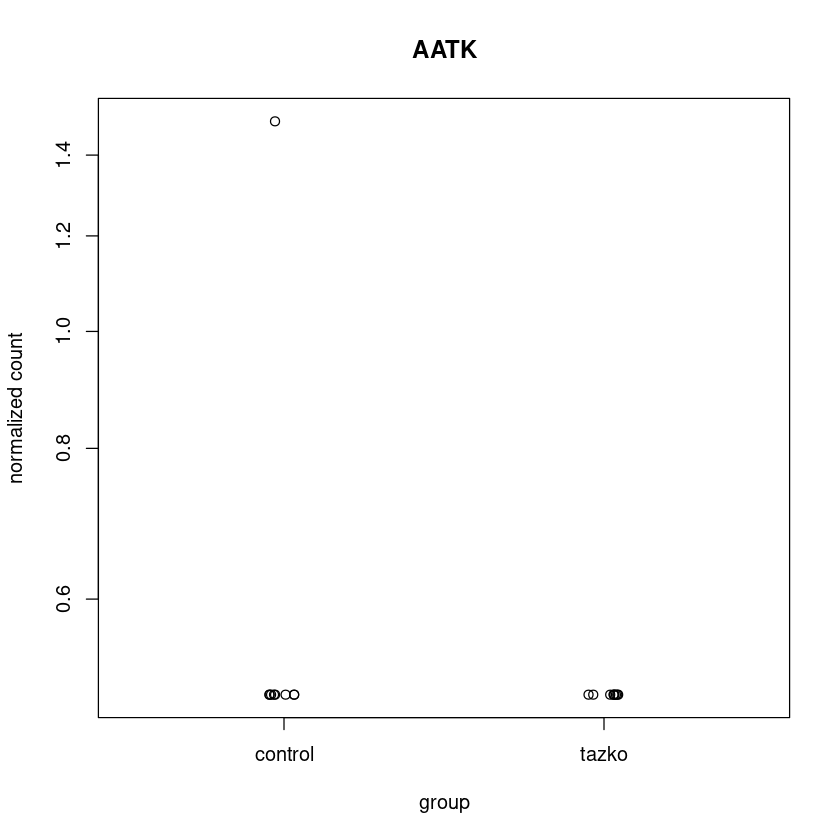

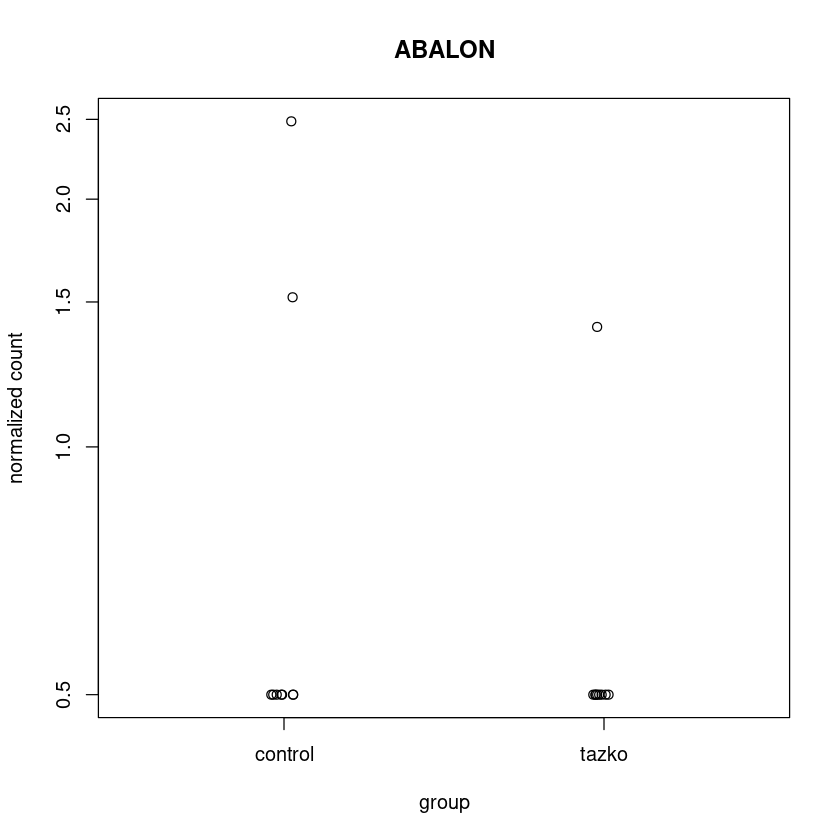

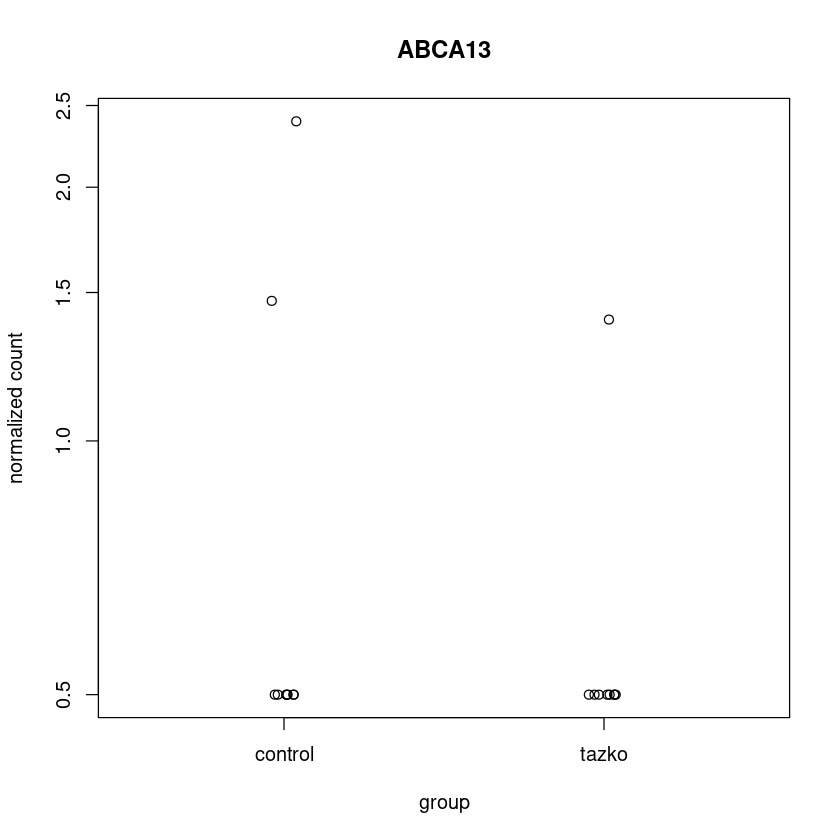

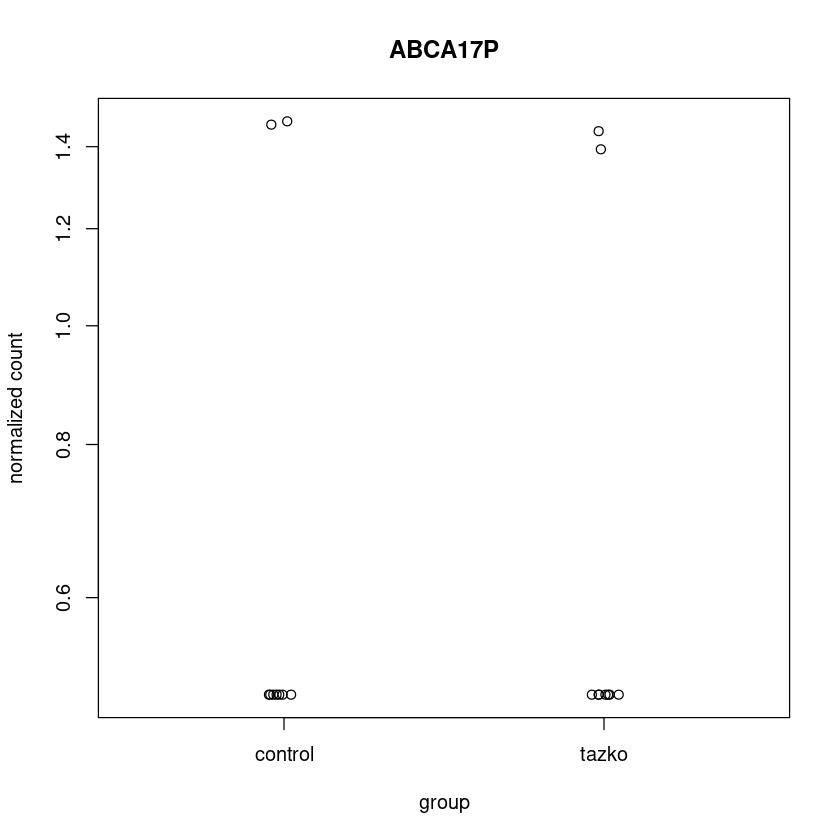

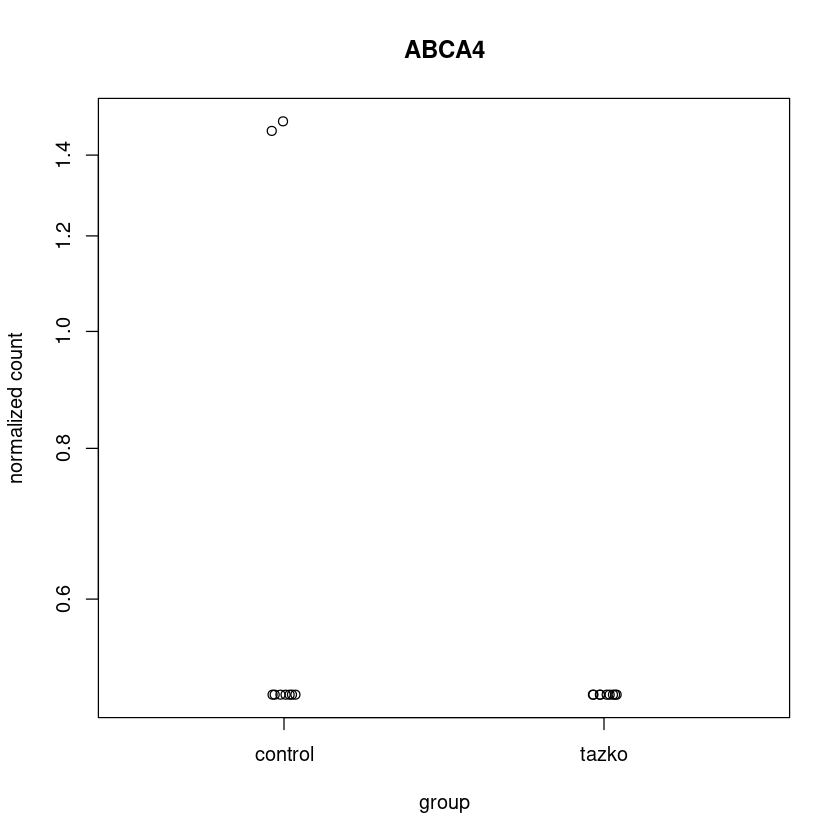

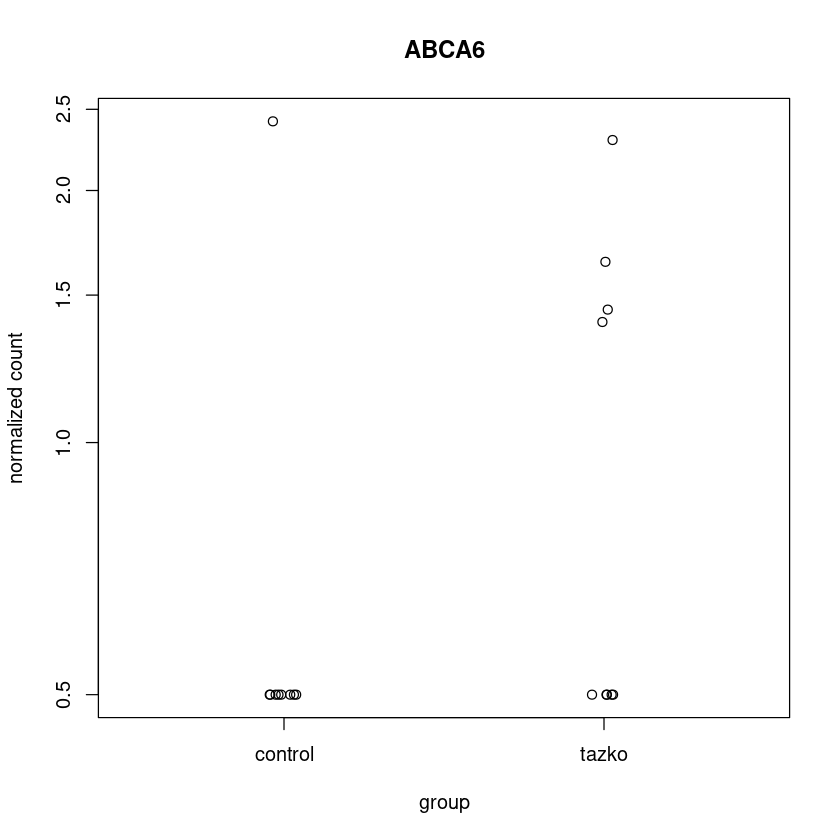

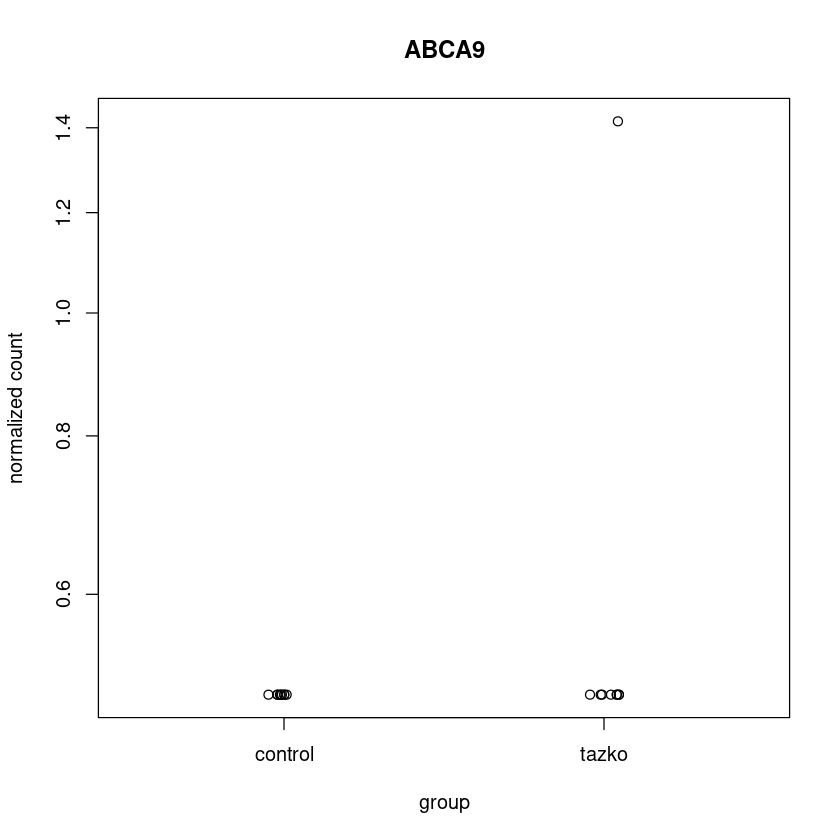

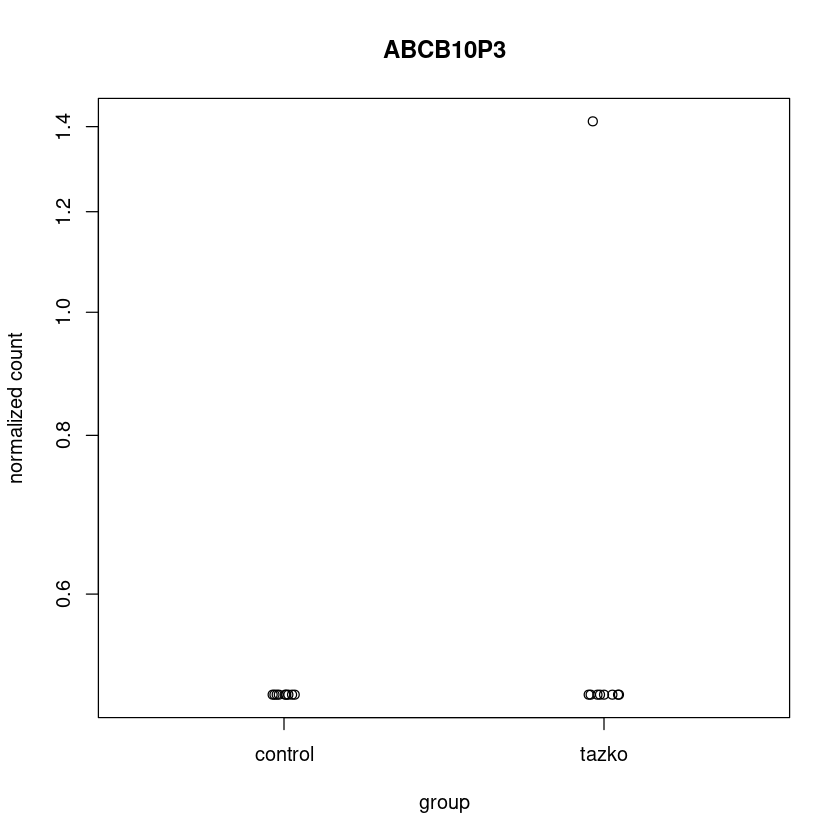

In [67]:
#We can iterate over the list to then plot the counts to take a look to see what is going on
#One common issue for a failure to converge is that there are outliers in our samples
#DESeq2 dumps these genes from its analysis if there are notable outliers
#and those genes are assigned a pvalue of na and are not used in the analysis
#Let's take a look at the counts using DESeq2's plotCounts() function
for (i in head(rownames(problems), 10)) {
    plotCounts(dds, 
               gene = i,
               intgroup = 'condition'
               )
}

Now let's take a look at the results and export them for use later:

In [60]:
write.csv(resLFC, '../Week_10/differential-expression-analysis/1M_results_lfcShrink.csv')

<h2>Plot MA plot for shrunken log fold change</h2>

Now let's take a look at how our MA plot looks like when we take into account that lower means are expected to have higher log fold change:

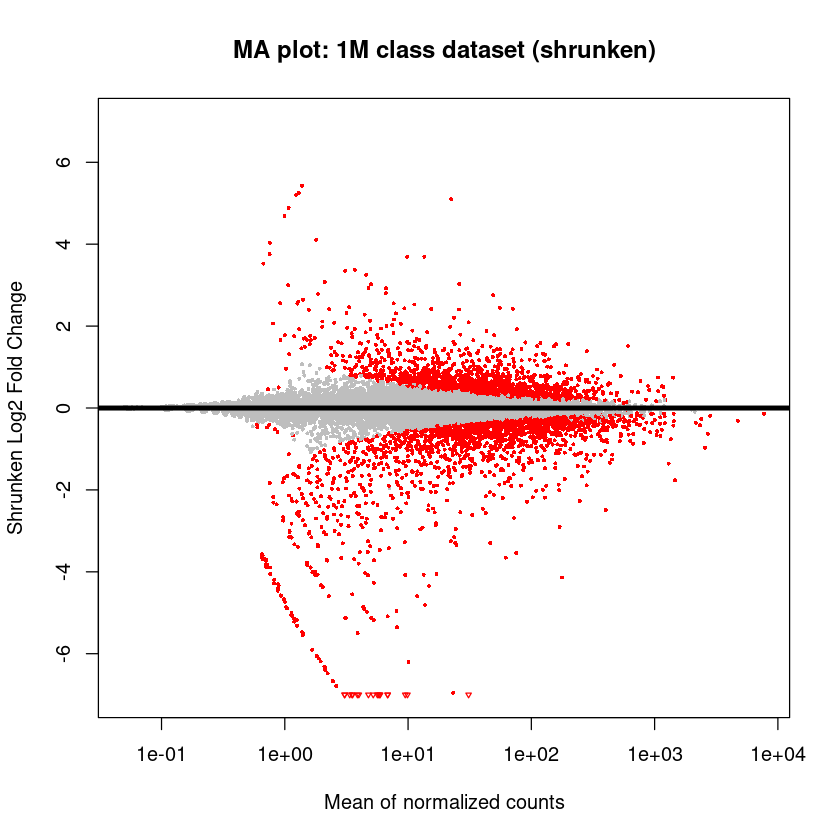

In [62]:
plotMA(resLFC,
       alpha=0.05,
       xlab='Mean of normalized counts',
       ylab='Shrunken Log2 Fold Change',
       main='MA plot: 1M class dataset (shrunken)',
       ylim=c(-7, 7),
       colNonSig='grey',
       colSig='red',
       colLine='black',
       )